In [4]:
!pip install transformers==4.40.0  # or latest
!pip install torch
!pip install torchvision
!pip install PyMuPDF transformers torch


In [5]:
from transformers import LayoutLMTokenizerFast, LayoutLMModel
from transformers import LayoutLMTokenizer, LayoutLMModel
import torch
import pandas as pd
device = torch.device("cuda")
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
model = LayoutLMModel.from_pretrained("microsoft/layoutlm-base-uncased")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
data =pd.read_csv('/kaggle/input/adobe-dataset-hackathon/dataset.csv')


/tmp/ipykernel_37/2224491078.py:1: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data =pd.read_csv('/kaggle/input/adobe-dataset-hackathon/dataset.csv')


In [7]:
data = data.dropna()

In [8]:
ids_all_para = data.groupby('id')['level'].apply(lambda x: (x == 'para').all())

# Step 2: Get the list of such ids
ids_to_drop = ids_all_para[ids_all_para].index

# Step 3: Drop all rows with those ids
data = data[~data['id'].isin(ids_to_drop)]


In [7]:
headings

array(['para', 'H1', 'H3', 'H2'], dtype=object)

In [9]:
headings = data.level.unique()[:4]

In [10]:
data = data[data.level.isin(headings)]

In [ ]:
data[].groupby("id")

In [5]:
data["id"].drop_duplicates().shape

(249,)

<Axes: >

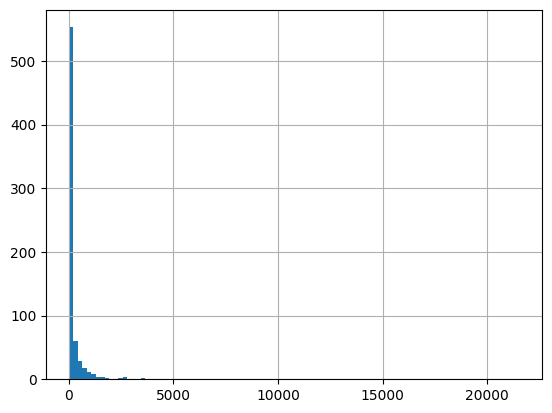

In [24]:
data.id.value_counts().hist(bins= 100)

In [6]:
# import ast
# from collections import defaultdict
# embeddings = defaultdict(list)
# labels = defaultdict(list)
# for idx, row in data.iterrows():
#     words = str(row.text).split()
#     box = ast.literal_eval(row.bbox)

#     tokens, token_boxes = [], []

#     for word in words:
#         word_tokens = tokenizer.tokenize(word)
#         if len(tokens) + len(word_tokens) >= 510:  # Reserve space for special tokens
#             break
#         tokens.extend(word_tokens)
#         token_boxes.extend([box] * len(word_tokens))

#     # Add special tokens
#     tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]
#     token_boxes = [[0, 0, 0, 0]] + token_boxes + [[0, 0, 0, 0]]

#     input_ids = tokenizer.convert_tokens_to_ids(tokens)
#     attention_mask = [1] * len(input_ids)
#     token_type_ids = [0] * len(input_ids)
#     max_len = 512
#     padding_length = max_len - len(input_ids)

#     # Padding
#     input_ids += [tokenizer.pad_token_id] * padding_length
#     attention_mask += [0] * padding_length
#     token_type_ids += [0] * padding_length
#     token_boxes += [[0, 0, 0, 0]] * padding_length

#     # Convert to tensors
#     input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)
#     attention_mask = torch.tensor([attention_mask], dtype=torch.long).to(device)
#     token_type_ids = torch.tensor([token_type_ids], dtype=torch.long).to(device)
#     bbox = torch.tensor([token_boxes], dtype=torch.long).to(device)

#     # Get CLS embedding
#     with torch.no_grad():
#         outputs = model(
#             input_ids=input_ids,
#             bbox=bbox,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids
#         )
#         cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
        
#     embeddings[row["id"]].append(cls_embedding.cpu().numpy()[0])
#     labels[row["id"]].append(row["level"])

In [76]:
import ast
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
import torch

class BBoxDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        words = str(row.text).split()
        box = ast.literal_eval(row.bbox)
        tokens, token_boxes = [], []

        for word in words:
            word_tokens = self.tokenizer.tokenize(word)
            if len(tokens) + len(word_tokens) >= self.max_len - 2:  # Reserve space for CLS and SEP
                break
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))

        # Add special tokens
        tokens = [self.tokenizer.cls_token] + tokens + [self.tokenizer.sep_token]
        token_boxes = [[0, 0, 0, 0]] + token_boxes + [[0, 0, 0, 0]]

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)
        token_type_ids = [0] * len(input_ids)

        padding_length = self.max_len - len(input_ids)

        # Padding
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        token_type_ids += [0] * padding_length
        token_boxes += [[0, 0, 0, 0]] * padding_length

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "bbox": torch.tensor(token_boxes, dtype=torch.long),
            "id": row["id"],
            "level": row["level"]
        }


In [105]:
data["length"] = data["text"].apply(lambda x:len(x))

In [77]:
dataset = BBoxDataset(data, tokenizer)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)


<Axes: >

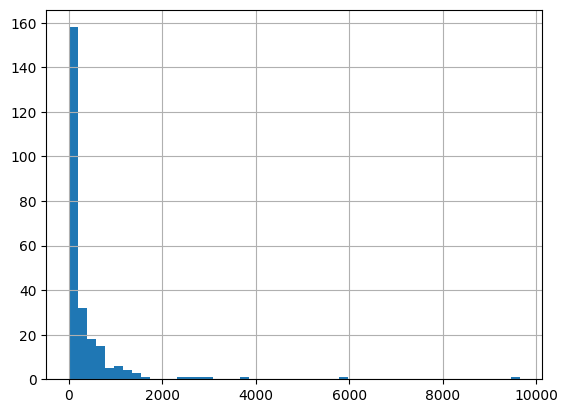

In [9]:
data.id.value_counts().hist(bins = 50)

In [78]:
embeddings = defaultdict(list)
labels = defaultdict(list)

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        bbox = batch["bbox"].to(device)
        bbox = torch.clamp(bbox, 0, 1000)

        outputs = model(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: [batch_size, hidden_size]

        for i, cls_emb in enumerate(cls_embeddings):
            id_ = batch["id"][i]
            level = batch["level"][i]
            embeddings[id_].append(cls_emb.cpu().numpy())
            labels[id_].append(level)


In [79]:
len(embeddings)

705

In [16]:
len(data.id.unique())

705

In [80]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(data.level.unique())

array([3, 0, 2, 1])

In [31]:
le.classes_

array(['H1', 'H2', 'H3', 'para'], dtype=object)

In [81]:
from sklearn.preprocessing import LabelEncoder
X = list(embeddings.values())
y = list(labels.values())

In [82]:
import numpy as np

# Example sequence of length 30 tokens
def paddend(sequence):
    # Pad so total length is 300
    array = np.array(sequence)
    if len(sequence)>1000:
        return sequence[:1000]
    padding_length = 1000 - array.shape[0]
    
    # Pad rows at the bottom (right-padding), zero-fill
    padded_array = np.pad(array, pad_width=((0, padding_length), (0, 0)), mode='constant', constant_values=0)
    return padded_array


In [83]:
for i in range(len(X)):
    X[i] = paddend(X[i])

In [32]:
le.classes_

array(['H1', 'H2', 'H3', 'para'], dtype=object)

In [84]:

def pad_label(label, max_len=1000):
    # Ensure label is a list, not a numpy array
    label = list(label)
    label = le.transform(label)
    shape = len(label)
    if shape > max_len:
        label = label[:max_len]
    else:
        padding = np.array([4]*(max_len -shape))
        label = np.concatenate([label,padding])
    return np.array(label)


In [18]:
le.classes

AttributeError: 'LabelEncoder' object has no attribute 'classes'

In [85]:
for i in range(len(y)):
    y[i] = pad_label(y[i])

In [86]:
X = np.array(X)
y = np.array(y)

In [87]:

np.save("input.npy", X)
np.save("labels.npy", y)


In [37]:
import numpy as np
X = np.load("/kaggle/input/adobe-model/input.npy")
y = np.load("/kaggle/input/adobe-model/labels.npy")

In [88]:
len(X)

705

In [39]:

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))




In [40]:
def extract_text_features(text):
    words = text.split()
    num_chars = len(text)
    num_words = len(words)
    avg_word_len = sum(len(w) for w in words) / max(1, num_words)

    capital_ratio = sum(1 for c in text if c.isupper()) / max(1, num_chars)
    is_all_caps = int(text.isupper())

    has_colon_or_dot = int(':' in text or '.' in text)
    ends_with_punct = int(text.strip()[-1] in ".!?") if len(text.strip()) > 0 else 0
    starts_with_number = int(text.strip()[0].isdigit()) if len(text.strip()) > 0 else 0

    stopword_count = sum(1 for w in words if w.lower() in stop_words)
    stopword_ratio = stopword_count / max(1, num_words)

    return pd.Series({
        'num_chars': num_chars,
        'num_words': num_words,
        'avg_word_len': avg_word_len,
        'capital_ratio': capital_ratio,
        'is_all_caps': is_all_caps,
        'has_colon_or_dot': has_colon_or_dot,
        'ends_with_punct': ends_with_punct,
        'starts_with_number': starts_with_number,
        'stopword_ratio': stopword_ratio
    })


In [20]:
df_features = data['text'].apply(extract_text_features)
data = pd.concat([data, df_features], axis=1)


In [41]:
wordfeatures = data[[ 'num_chars','num_words','avg_word_len','capital_ratio','is_all_caps','has_colon_or_dot','ends_with_punct','starts_with_number','stopword_ratio',"id"]]

In [42]:
feature_cols = [col for col in wordfeatures.columns if col != 'id']

# Step 3: Group by 'id' and collect features into sequences (list of rows per group)
grouped = wordfeatures.groupby('id')[feature_cols].apply(lambda df: df.to_numpy()).reset_index(name='features')

# Step 4: Pad each group to length 1000 with -1
MAX_LEN = 1000
PAD_VALUE = -1

def pad_sequence(seq, max_len=MAX_LEN, pad_value=PAD_VALUE):
    length, dim = seq.shape
    if length >= max_len:
        return seq[:max_len]
    else:
        pad = np.full((max_len - length, dim), pad_value)
        return np.vstack([seq, pad])

# Step 5: Apply padding
grouped['padded_features'] = grouped['features'].apply(pad_sequence)

# Step 6: Convert to final NumPy array (num_docs, 1000, num_features)
final_array = np.stack(grouped['padded_features'].to_numpy())

In [27]:
final_array.shape

(705, 1000, 36)

In [43]:
feats_id = wordfeatures.groupby('id').agg(list).to_numpy()

list

In [44]:
feats_id = np.array([np.array(row) for row in feats_id])


In [170]:
final_array.shape

(705, 1000, 9)

In [169]:
X.shape

(705, 1000, 768)

In [45]:
X_data = np.concatenate([X,final_array],axis =2)

In [46]:
X_data.shape

(705, 1000, 804)

In [142]:
np.array(a).shape


(9, 186)

In [130]:
feats_id.columns


Index(['num_chars', 'num_words', 'avg_word_len', 'capital_ratio',
       'is_all_caps', 'has_colon_or_dot', 'ends_with_punct',
       'starts_with_number', 'stopword_ratio'],
      dtype='object')

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        output_features = X[:,:,-9:]
        X = X[:,:,:-9]
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.output = torch.tensor(output_features,dtype = torch.float32)
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx],self.output[idx]

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

train_ds = EmbeddingDataset(X_train, y_train)
test_ds = EmbeddingDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [32]:
import torch
import torch.nn as nn

class TransformerTokenClassifier(nn.Module):
    def __init__(self, input_dim=768, seq_len=1000, num_classes=5, num_heads=2, num_layers=3, dropout=0.1):
        super().__init__()
        # Learnable positional encoding: [1, seq_len, input_dim]
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, input_dim))
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Per-token classification head
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x, attention_mask=None):
        # x: [batch_size, seq_len, input_dim]
        x = x + self.positional_encoding

        # Attention mask for padding (optional, helps mask out padded positions)
        if attention_mask is not None:
            # attention_mask: [batch_size, seq_len] -- 1 for real, 0 for pad
            # Transformer expects mask where True = positions to mask
            key_padding_mask = ~attention_mask.bool()  # invert
        else:
            key_padding_mask = None

        # Pass through transformer encoder
        x = self.transformer_encoder(x, src_key_padding_mask=key_padding_mask)
        # Output logits for each token/block
        logits = self.classifier(x)  # [batch_size, seq_len, num_classes]
        return logits


In [18]:
device


device(type='cuda')

In [ ]:
le.classes_

In [ ]:
y =  data["level"].to_numpy()

In [25]:
device  = torch.device("cuda")

NameError: name 'all_train_labels' is not defined

In [94]:
class DeeperMLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=512, output_dim=5):
        super(DeeperMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [51]:
weights

tensor([65.1604, 58.8061, 51.6615, 89.8826,  0.7554,  0.2168], device='cuda:0')

In [101]:
import torch
import torch.nn as nn

class CNNPerTimestepMLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=5):
        super(CNNPerTimestepMLP, self).__init__()
        clasifier = HeadingClassifier()
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=768, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(768, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.output_layer = 

    def forward(self, x):  # x: (batch_size, seq_len=1000, input_dim=768)
        x = x.permute(0, 2, 1)  # → (batch_size, input_dim=768, seq_len=1000)
        x = self.conv1d(x)       # → (batch_size, hidden_dim, seq_len=1000)
        x = x.permute(0, 2, 1)   # → (batch_size, 1000, hidden_dim)
        output = self.output_layer(x)  # → (batch_size, 1000, output_dim=5)
        return output


In [35]:
import torch
import torch.nn as nn

class CNNEmbeddingBranch(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768):
        super(CNNEmbeddingBranch, self).__init__()
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=768, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(768, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):  # x: (batch_size, seq_len, input_dim)
        x = x.permute(0, 2, 1)         # → (batch_size, input_dim, seq_len)
        x = self.conv1d(x)             # → (batch_size, hidden_dim, seq_len)
        x = x.permute(0, 2, 1)         # → (batch_size, seq_len, hidden_dim)
        return x                       # output shape: (batch_size, 1000, hidden_dim)


In [33]:
class HeadingClassifierWithSizeBranch(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, feat_dim=9, output_dim=5):
        super(HeadingClassifierWithSizeBranch, self).__init__()

        self.embedding_branch = CNNEmbeddingBranch(input_dim=input_dim, hidden_dim=hidden_dim)

        # Size feature branch — 1 MLP per timestep
        self.feature_branch = nn.Sequential(
            nn.Linear(feat_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Combine both and classify per timestep
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + 64, hidden_dim),
        
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, embeddings, size_features):
        """
        embeddings: (batch, seq_len, 768)
        size_features: (batch, seq_len, 4)
        """
        emb_out = self.embedding_branch(embeddings)     # (batch, seq_len, hidden_dim)
        feat_out = self.feature_branch(size_features)   # (batch, seq_len, 64)
        combined = torch.cat([emb_out, feat_out], dim=-1)# (batch, seq_len, hidden_dim + 64)
        out = self.classifier(combined)                 # (batch, seq_len, output_dim)
        return out


In [36]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn.functional as F

# Assuming you have a list of all training labels
all_train_labels = []
for _, batch_y,_ in train_loader:
    all_train_labels.extend(batch_y.view(-1).tolist())

# Compute class weights
classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_train_labels)
weights = torch.tensor(weights, dtype=torch.float).to(device)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=3):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        logp = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(logp, targets, reduction='none', weight=self.weight)
        p = torch.exp(-ce_loss)
        loss = ((1 - p) ** self.gamma * ce_loss).mean()
        return loss

criterion = FocalLoss(weight=weights)

# Add weights to loss

from sklearn.metrics import accuracy_score
from torch.optim import Adam
from tqdm import tqdm

model = HeadingClassifierWithSizeBranch().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',       # or 'max' if monitoring accuracy
    factor=0.5,       # reduce LR by this factor
    patience=4,       # epochs to wait before reducing LR
    min_lr=1e-8,      # minimum LR
    verbose=True      # print update messages
)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

    for batch_x, batch_y,feats in train_bar:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        feats = feats.to(device)
        outputs = model(batch_x,feats)  # shape: (batch_size, 768, ...)
        outputs = outputs.view(-1, 5)
        batch_y = batch_y.view(-1)

        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]", leave=False)
    testloss = 0
    with torch.no_grad():
        for test_x, test_y,feats in test_bar:
            test_x, test_y,feats = test_x.to(device), test_y.to(device),feats.to(device)

            test_outputs = model(test_x,feats)
            test_outputs = test_outputs.view(-1, 5)
            test_y = test_y.view(-1)

            test_preds = torch.argmax(test_outputs, dim=1)
            all_preds.extend(test_preds.cpu().numpy())
            all_labels.extend(test_y.cpu().numpy())
            testloss += criterion(test_outputs, test_y)
    
    acc = accuracy_score(all_labels, all_preds)
    scheduler.step(testloss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Test Acc: {acc:.4f} testloss: {testloss/len(test_loader)}")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    print(classification_report(all_labels,all_preds))
    

RuntimeError: Given groups=1, weight of size [768, 768, 3], expected input[32, 795, 1000] to have 768 channels, but got 795 channels instead

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[   77    14    18    14     0     0]
 [  137    66    17    34     0     0]
 [   19    16    14    43     0     0]
 [    7    90     4     6     0     0]
 [ 4835  2828  1326  5006     0     0]
 [ 1497  3270  8041 22377     0   244]]


In [185]:
from sklearn.metrics import confusion_matrix,classification_report

cm = confusion_matrix(all_labels, all_preds)
print(cm)

[[   174     97     31     69      0]
 [    65    213    140    175      0]
 [    37    174    189    107      0]
 [  1034   2255   2372  14018      1]
 [     1      0      3      0 119845]]


In [54]:
le.classes_

array(['H1', 'H2', 'H3', 'para'], dtype=object)

In [194]:
def remap_labels(label):
    if label in [0, 1, 2]:
        return 0
    elif label == 3:
        return 1
    elif label == 4:
        return 1
    else:
        return label  # fallback for unexpected values

# Apply to list
labels = all_labels
all_labels = [remap_labels(l) for l in labels]
labels = all_preds
all_preds = [remap_labels(l) for l in labels]



In [195]:
print(classification_report(all_labels,all_preds))

              precision    recall  f1-score   support

           0       0.15      0.76      0.25      1471
           1       1.00      0.95      0.98    139529

    accuracy                           0.95    141000
   macro avg       0.57      0.86      0.61    141000
weighted avg       0.99      0.95      0.97    141000



In [74]:
data.level.value_counts()

level
para    84020
H2        855
H3        827
H1        714
H4        682
Name: count, dtype: int64